In [1]:
import os
import time
import shutil
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [4]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [5]:
data['label'].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

# Unequal Data in Classes

In [7]:
from imblearn.over_sampling import RandomOverSampler 

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [8]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6], dtype=int64)

In [9]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [22]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 42)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


In [24]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [25]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

In [26]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

# Model

In [27]:
model = keras.models.Sequential()

model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=256, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 64)         

In [28]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=25 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/25
276/276 [==============================] - 67s 227ms/step - loss: 1.1913 - accuracy: 0.5646 - val_loss: 0.9881 - val_accuracy: 0.6403 - lr: 0.0010
Epoch 2/25
276/276 [==============================] - 60s 219ms/step - loss: 0.5090 - accuracy: 0.8275 - val_loss: 0.3575 - val_accuracy: 0.8746 - lr: 0.0010
Epoch 3/25
276/276 [==============================] - 60s 217ms/step - loss: 0.2832 - accuracy: 0.9034 - val_loss: 0.2735 - val_accuracy: 0.8998 - lr: 0.0010
Epoch 4/25
276/276 [==============================] - 61s 220ms/step - loss: 0.1887 - accuracy: 0.9373 - val_loss: 0.2067 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 5/25
276/276 [==============================] - 60s 217ms/step - loss: 0.1432 - accuracy: 0.9505 - val_loss: 0.1508 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 6/25
276/276 [==============================] - 60s 217ms/step - loss: 0.0987 - accuracy: 0.9663 - val_loss: 0.1509 - val_accuracy: 0.9454 - lr: 0.0010
Epoch 7/25
276/276 [==============================] 

In [29]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

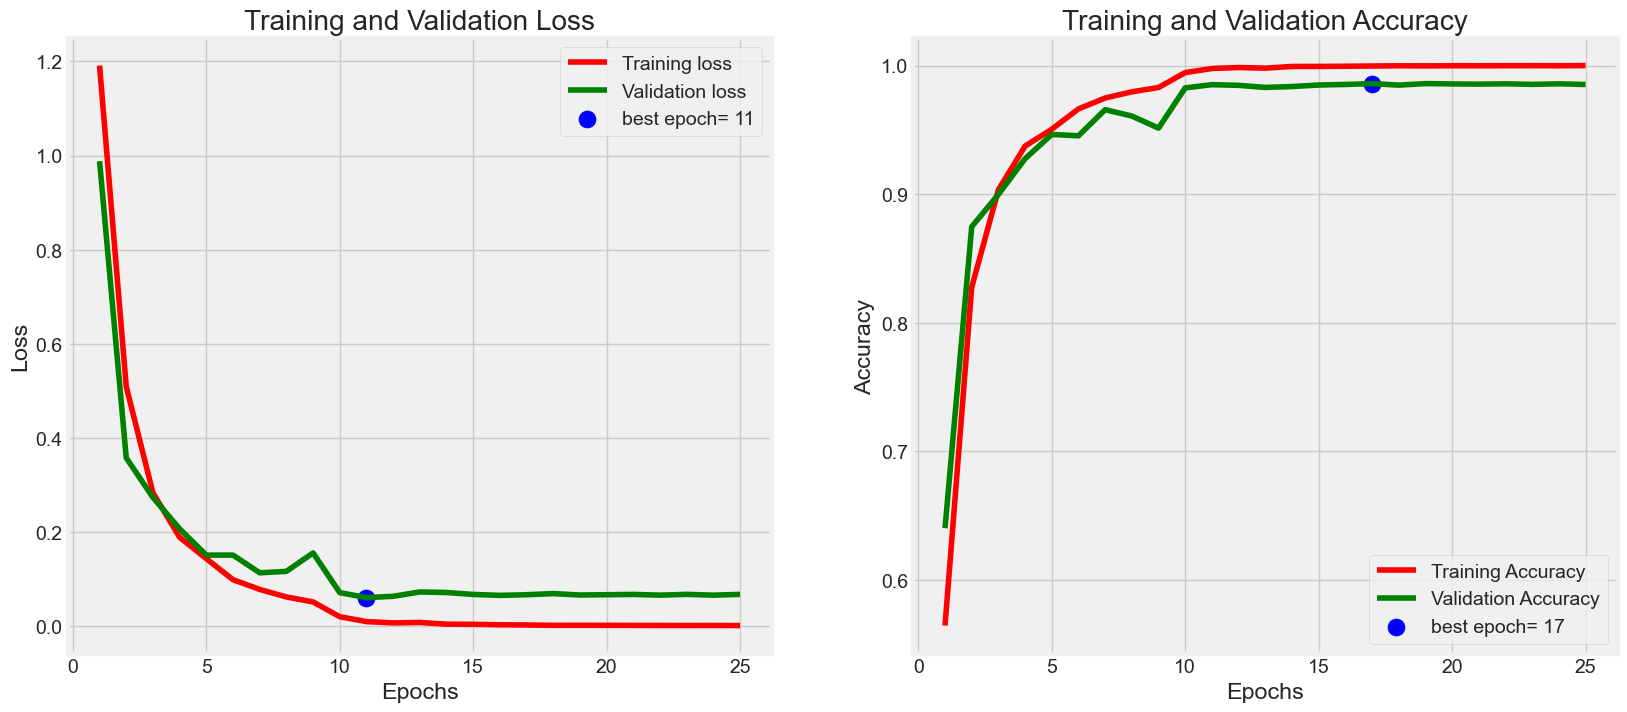

In [30]:
plot_training(history)

In [31]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 8s 22ms/step - loss: 0.0674 - accuracy: 0.9853
Train Loss:  0.0001450953132007271
Train Accuracy:  1.0
--------------------
Test Loss:  0.06741223484277725
Test Accuracy:  0.9852564930915833


In [32]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 [==============================] - 8s 22ms/step


In [33]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


In [35]:
report = classification_report(y_true, y_pred)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1635
           1       0.99      1.00      0.99      1636
           2       0.97      1.00      0.98      1692
           3       1.00      1.00      1.00      1740
           4       1.00      0.91      0.95      1699
           5       1.00      1.00      1.00      1611
           6       0.96      0.99      0.97      1721

    accuracy                           0.99     11734
   macro avg       0.99      0.99      0.99     11734
weighted avg       0.99      0.99      0.99     11734



In [36]:
cm=confusion_matrix(y_true,y_pred,labels=classes_labels)
print(confusion_matrix(y_true,y_pred,labels=classes_labels))

[[1547   72   49   22    2    3    4]
 [   2 1706   11    2    0    0    0]
 [   4    2 1686    0    0    0    0]
 [   0    0    0 1636    0    0    0]
 [   0    0    0    0 1611    0    0]
 [   0    0    0    0    0 1635    0]
 [   0    0    0    0    0    0 1740]]


<AxesSubplot: >

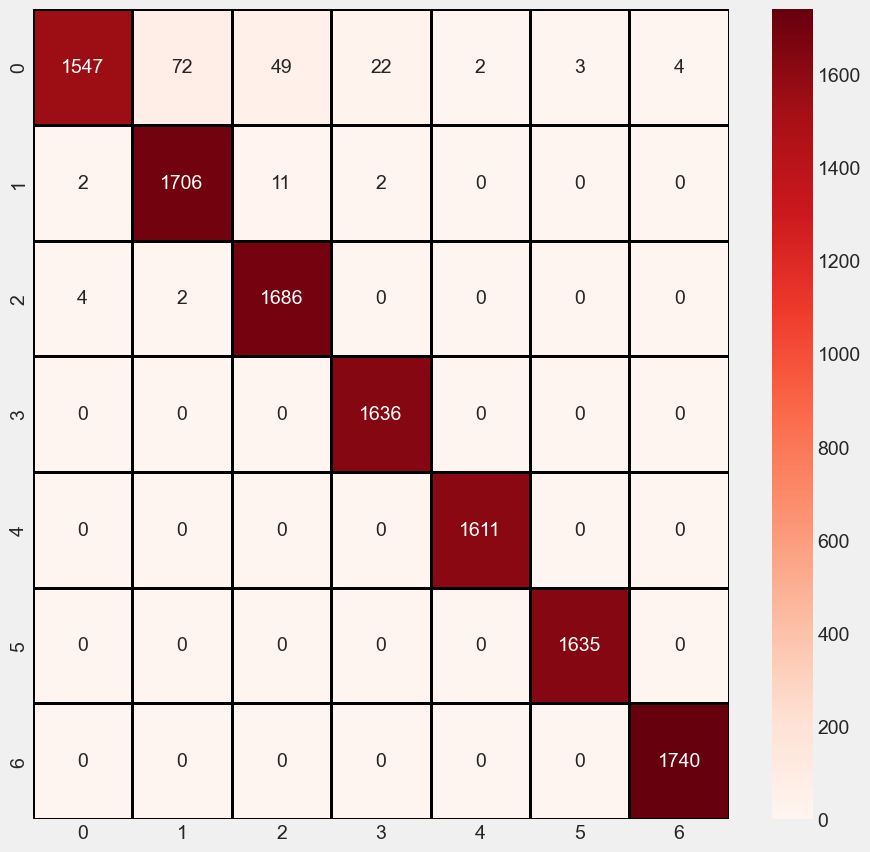

In [37]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')